## Horizon Detetction in images using K Means Clustering

Horizon Detection is detecting the line that separates the sky from the terrain or waterbody. 
It can be used in Unmanned Aerial Vehicles or (UAVs) or Drones. Obstacle Detection is a problem for drones and detecting the horizon can help drones separate the sky from the terrain. This is because: 



· They need real time response
<br>
· High speed for Aerial vehicles
<br>
· There are varying light conditions
<br>
· Different types of terrains
<br>
<br>
Drones have many applications: 
<br>
<br>
· Military<br>
· Business<br>
· Marine Navigation<br>
· Hurricane Hunting<br>

<br>

We have implemented the paper titled <b>'Robust Horizon Detection using Segmentation for UAV Applications’</b>. This approach uses K means Clustering as it's main tool to detect the horizon, finds subclusters using Union Find Algorithm and then finds the cluster with the minimum number of pixels to find the ROI(Region of Interest).


We diagress a little from the paper in our approach. We apply K means clustering, subcluster our image and then use a <b> Greedy Alorithm </b> to mark the ROI(Region of Interest) and then subsequently mark the horizon. 



Flow of the approach: 
<br>
<br>
<img src="diagram.png" align="center" />

<br>
<br>
For pre-processing we convert the image into gray scale from RGB and resize the image to help our computer process the image efficiently. 
<br>
<br>
<br>
<br>
<br>
<br>



In [271]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
from scipy.misc import face
import sys
import cv2

In [272]:
# We are doing a depth first search
sys.setrecursionlimit(30000)
num_clusters = 8

In [273]:
 def rgb2grayscale(im):
        """
            Converts RGB to Grayscale.
            @params: Input RGB image.
            @return: Grayscale image(1 channel)
        """
        if  len(im.shape) > 2:
            if im.shape[2] == 3: # Convert RGB image to Grayscale
                r, g, b = im[:, :, 0], im[:, :, 1], im[:, :, 2]
                grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
                return grayscale
        else:
            return im

In [274]:
#im = Image.open("horizon1.jpg")
input_file = 'Test4.jpg'
im = cv2.imread(input_file)
h,w,c = im.shape
# Resize image due to recursion limitation
while (h>400 or w > 400):
    im = cv2.resize(im, dsize=(w//2, h//2), interpolation=cv2.INTER_CUBIC)
    h,w,c = im.shape

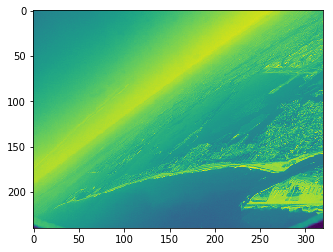

In [275]:
img  = rgb2grayscale(np.array(im))
width, height = img.shape
# flatten image
img_ = img.reshape(-1,1)
plt.imshow(img)

## We now apply K means clustering 
<br>
<br>

<b>What is K means clustering?</b>
<br>
<br>

K-means is a classification based method that groups a number of objects into a predefined clusters. In this case the objects are pixels of the image. The classification is based on the similarity between each object and each cluster's center point. This means, that the cluster which  is assigned to the object that has the most similarity to a group's center point or the centroid. 

<br>
<br>
<br>
<img src="diagram2.png" align="center" />

<br>
<br>
<br>

First, some number of center points are randomly selected. The center points will be updated in the next step. The center points will be updated in further steps. This is done by calculating the average of all of the cluster's current points and taking the average as the new center point for that group. Then, all the points are divided into new clusters with new centroids.This is continued until a certain convergence criterion is met. The points are assigned based on the following equations (1) & (2)

<br>
<br>
<br>

<img src="eq 1.png" align="center" />
<img src="eq2.png" align="center" />


In [276]:
kmeans = KMeans(n_clusters=8).fit(img_)

In [277]:
values = kmeans.cluster_centers_.squeeze()
labels = kmeans.labels_

In [278]:
img_compressed = np.choose(labels, values)
img_compressed.shape = img.shape

<b> This is our K means Labels Output</b>

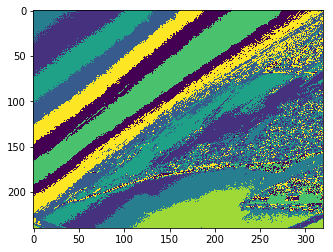

In [279]:
labels_reshaped = labels.reshape(width, height)
plt.imshow(labels_reshaped)

In [280]:
sub_clusters = np.zeros((width,height), dtype=np.uint32)

cnt=1
for j in range(height):
    for i in range(width):
        sub_clusters[i,j]=cnt
        cnt +=1
sub_clusters.shape

(240, 320)

In [281]:
visited =  np.zeros((width, height), dtype=bool)

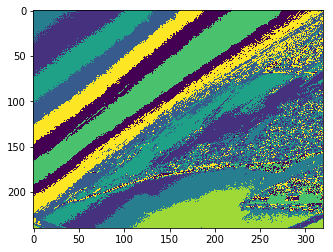

In [282]:
plt.imshow(labels_reshaped)

## Connected componenet Labeling 

<br>
<br>
<br>
Connected-component labeling alternatively connected-component analysis, blob extraction, region labeling, blob discovery, or region extraction is an algorithmic application of graph theory, where subsets of connected components are uniquely labeled based on a given heuristic.

<br>
<br>
<br>
<img src="8 Connect.png" align="center" />

<br>
<br>
<br>

<img src="ccl1.png" align="center" />


<br>
<br>
<br>

In [283]:
def connect_labels(x, y, in_labels):
    visited[x,y] = True
    #print(x,y)
    if not in_labels[x,y]:
        return
    for i in range(-1,2):
        for j in range(-1,2):
            if x+i > 0 and x+i < width and y+j > 0 and y+j < height and not(i==0 and j==0):
                if not visited[x+i,y+j]:
                    if in_labels[x,y] == in_labels[x+i,y+j]:
                    #if labels_reshaped[x,y] == labels_reshaped[x+i,y+j]:
                        sub_clusters[x+i,y+j] = sub_clusters[x,y]
                        connect_labels(x+i, y+j, in_labels)

In [284]:
for l in range(6):
    in_labels = labels_reshaped==l
    visited =  np.zeros((width, height), dtype=bool)
    for i in range(width):
        for j in range(height):
            if not visited[i,j]:
                connect_labels(i,j, in_labels)

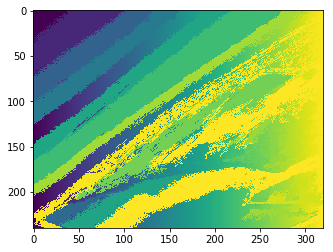

In [285]:
plt.imshow(sub_clusters)

## Output of Connected Component labeling 

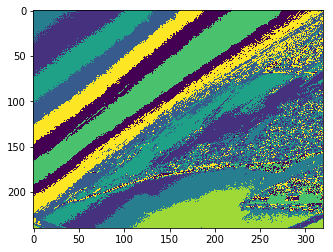

In [286]:
plt.imshow(labels_reshaped)

In [287]:
d = {}
for sub_cluster_val in np.unique(sub_clusters):
    sub_cluster_sample = sub_clusters==sub_cluster_val
    num_pixels = np.sum(sub_cluster_sample).astype(np.uint32)
    width_check = np.zeros((1,height),dtype=np.uint16)
    for row in range(width):
        width_check = np.bitwise_or(width_check,sub_cluster_sample[row,:])
    
    d[str(sub_cluster_val)] = (num_pixels,np.sum(width_check),np.sum(width_check)/num_pixels)

In [288]:
min_pixels = width*height
horizon = []
_max = 0
for k in d.keys():
    if d[k][2]*d[k][1] > _max and not d[k][2] == 1:
        _max = d[k][2]*d[k][1]
        sol = k

In [289]:
print(_max)

25.145850565205404


In [290]:
#for k in d.keys():
#    if d[k][1] > max_width*1//2:
#        horizon.append(int(k))
#        if d[k][0] < min_pixels:
#            min_pixels = d[k][0]

## Applying our greedy choice property


We used a greedy approach to select that one sub cluster that gives us our ROI(Region of Interest). 

We checked all the sub clusters to find the one cluster that gives the maximum value of the function below  :

<br>

## (Width)²/No. of pixels    
Where width is the width of the sub cluster which is divided by the number of sub pixels. 


<br>



## <b>Here we get one cluster which defines the horizon line</b>

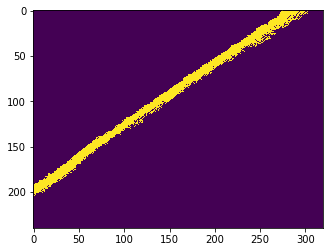

In [291]:
plt.imshow(sub_clusters == int(sol))

### Create the mask and mark the horizon pixels

In [292]:
for i in range(width):
    for j in range(height):
        if (sub_clusters == int(sol))[i,j]:
            im[i,j,2] = 255

<br>
<br>
<br>

## <b> Here we color the horizon red in our final output</b>
<br>
<br>
<br>
<br>
<br>
<br>

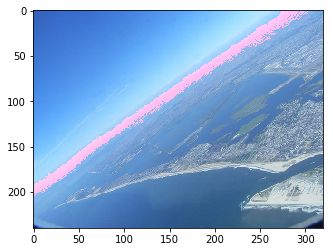

In [293]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [294]:
outfile = input_file.split('.')[0]+'_out_kmeans_'+str(num_clusters)+'.jpg'

In [295]:
plt.imsave(outfile,cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

<br>
<br>
<br>

## Analysis & Results

<br>
<br>
<br>
<img src="Analysis1.png" align="center" />
<br>
<br>
<br>
<img src="HorizonDetected1.png" align="center" />
<br>
<br>
<br>


## Observations: 
<br>
<br>

1.	For images with a distinct difference between the sky and the terrain and without natural landforms such as mountains, the horizon detection is fairly accurate. 
<br>
<br>
2.	The algorithm does not give great results for images where there are natural landforms. 
<br>
<br>
3.	For images with manmade forms like buildings, the algorithm gives decent results. 
<br>
<br>
<br>
